<h1 align='center'>Домашнее задание</h1>

**Дополнительный материал для выполнения дз**:

- Лекция Coursera: https://ru.coursera.org/learn/machine-learning/lecture/4BHEy/regularized-logistic-regression
- Статья на Хабре: https://habrahabr.ru/company/io/blog/265007/
- Книжка ISLR, 4 глава: http://www-bcf.usc.edu/~gareth/ISL/ISLR%20First%20Printing.pdf
- Логистическая регрессия, UFLDL Tutorial: http://ufldl.stanford.edu/tutorial/supervised/LogisticRegression/
- Линейная регрессия, UFLDL Tutorial: http://ufldl.stanford.edu/tutorial/supervised/LinearRegression/


<h1 align='center'>Logistic Regression</h1>

In [1]:
import pandas as pd
import numpy as np
import tqdm # interactive progress bar

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

%matplotlib inline

# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## 1. Знакомство с данными
Данные представляют собой выборку отзывов о еде с сайта Амазон. Для них проставлены метки -- положительный или отрицательный отзыв.

In [2]:
train_df = pd.read_csv('./data/train.csv')

In [3]:
print(train_df.shape)

(110163, 3)


In [4]:
train_df.Prediction.value_counts(normalize=True)

0    0.50074
1    0.49926
Name: Prediction, dtype: float64

Видим, что классы сбалансированы. Можем оценивать качество модели по метрике ```accuracy```.

In [5]:
train_df.head()

,ID,Reviews_Summary,Prediction
0,239071,Michigan Cherries,1
1,466160,Great Product,1
2,397133,Ovaltine,1
3,297146,~,1
4,292685,Love it!,1


In [6]:
train_df.tail()

,ID,Reviews_Summary,Prediction
110158,486256,Terrible!,0
110159,199050,"Cheap Coffee, No Banana Flavor",0
110160,278179,Not as described,0
110161,87500,Tastes like a squirt of toothpaste mixed into ...,0
110162,121963,Disappointed,0



----------
## 2. Извлечение признаков
Для решения задачи классификации необходимо преобразовать каждый отзыв (документ) в вектор. Размерность данного вектора будет равна количеству слов используемых в корпусе (все документы). Каждая координата соответствует слову, значение в координате равно количеству раз, слово используется в документе. 

Для решения данной задачи напишем код, который преобразовывает матрицу документов в численную матрицу.

Дополнительная информация:

- Подробнее про векторное представление документов: http://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction
- Разряженные матрицы: http://www.scipy-lectures.org/advanced/scipy_sparse/
- Трансформер: http://scikit-learn.org/stable/modules/feature_extraction.html#common-vectorizer-usage
- Подробнее про разреженные матрицы: http://docs.scipy.org/doc/scipy-0.14.0/reference/sparse.html
- Hashing trick: https://en.wikipedia.org/wiki/Feature_hashing

Помните, что все эти трансформеры возвращают ```sparse```-матрицы. Учитывая это и то, что линейные модели достаточно хорошо масштабируются на большое количество фич, можно смело ставить ```n_features``` 1000+.

In [7]:
train_df['Reviews_Summary'].str.lower().to_list()

['michigan cherries',
 'great product',
 'ovaltine',
 '~',
 'love it!',
 'yummy gf cereal',
 'satisfied completely with amazon purchase',
 'perfect chicken mix',
 'best seved cold!!',
 'worth the price',
 'the best pizza flour',
 'pie making with sweet rice flour',
 'good and cheap',
 'great treats for the treat ball.',
 'the babies love it',
 'better than fresh fruit',
 'best bar!!',
 'remember charlie the tuna?',
 'best ever!!!',
 'great sparkling apple soda drink',
 'dentyne gum',
 'so cute',
 'well done',
 'great as a treat within a well-balanced baby diet',
 'the best dog food!',
 'fresh!',
 'great',
 'great product',
 'overall winner in the office',
 'taste good and are filling.',
 'great tasting maple syrup',
 'my yorkiepoo ate it like a treat... we mixed it with his pedigree',
 'stash brand teas: a personal favorite for 10+ years',
 'high quality matcha',
 'makes a good cuppa coffee',
 'dog loves it!',
 'love twinings decaff!',
 'yummy',
 'yum',
 'real chocolate, fine quality &

In [8]:
review_summaries = train_df['Reviews_Summary'].str.lower().to_list()

In [9]:
review_summaries[:5]

['michigan cherries', 'great product', 'ovaltine', '~', 'love it!']

Преобразуем ```review_summaries``` с помощью ```TfidfVectorizer```.

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [11]:
vectorizer = TfidfVectorizer()

In [12]:
tfidfed = vectorizer.fit_transform(review_summaries)

In [13]:
tfidfed

<110163x16230 sparse matrix of type '<class 'numpy.float64'>'
	with 433667 stored elements in Compressed Sparse Row format>

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
X = tfidfed
y = train_df.Prediction.values
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)

## 3. Логистическая регрессия

Логистическая регрессия -- линейный классификатор, который очень часто используется на практике, например, в кредитном скоринге. Преимущества этой модели -- скорость обучения и предсказания (даже при сотнях тысяч фичей) а также интепретируемость: важные признаки имеют бОльшие по модулю веса. 

При этом отрицательные веса говорят, что фича важна для определения класса 0, а положительные -- для определения класса 1. Это можно понять, если вспомнить, что разделяющая поверхность линейных моделей, это $w^Tx = 0$, а значение алгоритма есть $a(x) = sign(w^Tx)$.

Будем предсказывать сентимент, подготовим данные и сделаем валидационную выборку. При этом нужно оценивать качество модели не по обучающей выборке, а по валидационной. Иначе вы переобучитесь, когда будете тюнить гиперпараметры модели.

-----
** Реализуйте код в модуле ```dmia.classifiers.logistic_regression```.**

-----

In [16]:
from dmia.gradient_check import *
from dmia.classifiers import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

## Gradient check

В этой ячейке вы можете проверить, правильно ли у вас все работает, прежде чем обучать модель на всех данных.

In [17]:
X_train_sample = X_train[:10000]
y_train_sample = y_train[:10000]
clf = LogisticRegression()
clf.w = np.random.randn(X_train_sample.shape[1]+1) * 2
loss, grad = clf.loss(LogisticRegression.append_biases(X_train_sample), y_train_sample, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
f = lambda w: clf.loss(LogisticRegression.append_biases(X_train_sample), y_train_sample, 0.0)[0]
grad_numerical = grad_check_sparse(f, clf.w, grad, 10)

numerical: -0.000027 analytic: -0.000027, relative error: 1.246249e-07
numerical: 0.000000 analytic: 0.000000, relative error: nan
numerical: 0.000000 analytic: 0.000000, relative error: nan
numerical: -0.000093 analytic: -0.000093, relative error: 3.943146e-09
numerical: 0.000000 analytic: 0.000000, relative error: nan
numerical: 0.000045 analytic: 0.000045, relative error: 4.377067e-08
numerical: 0.000000 analytic: 0.000000, relative error: nan
numerical: 0.000039 analytic: 0.000039, relative error: 3.007738e-08
numerical: 0.000093 analytic: 0.000093, relative error: 2.086251e-08
numerical: -0.000273 analytic: -0.000273, relative error: 8.046214e-09


/home/shevelsm/code/otus-python-pro/hw7-logistic-regression/dmia/gradient_check.py:50: RuntimeWarning: invalid value encountered in scalar divide
  rel_error = abs(grad_numerical - grad_analytic) / (


Обучите свою модель на ```X_train, y_train```.

Для начала можете взять параметры по умолчанию, и найти оптимальные используя валидацию.

In [18]:
clf = LogisticRegression()

In [29]:
clf.w = np.random.randn(X_train_sample.shape[1] + 1) * 2
clf.train(X_train, y_train, learning_rate=0.1, num_iters=1100, batch_size=1000, reg=0.1, verbose=True)

iteration 0 / 1100: loss 6471.760182
iteration 100 / 1100: loss 867.442291
iteration 200 / 1100: loss 116.781192
iteration 300 / 1100: loss 16.239251
iteration 400 / 1100: loss 2.773972
iteration 500 / 1100: loss 0.971763
iteration 600 / 1100: loss 0.730048
iteration 700 / 1100: loss 0.698317
iteration 800 / 1100: loss 0.693507
iteration 900 / 1100: loss 0.693940
iteration 1000 / 1100: loss 0.692706


Посмотрим на качество на валидации.

In [30]:
print("Train f1-score = %.3f" % accuracy_score(y_train, clf.predict(X_train)))
print("Test f1-score = %.3f" % accuracy_score(y_test, clf.predict(X_test)))

Train f1-score = 0.776
Test f1-score = 0.770


Нарисуем кривые обучения.

In [31]:
clf = LogisticRegression()
train_scores = []
test_scores = []
num_iters = 1000

for i in tqdm.trange(num_iters):
    # Сделайте один шаг градиентного спуска с помощью num_iters=1
    clf.train(X_train, y_train, learning_rate=1.0, num_iters=1, batch_size=256, reg=1e-3)
    train_scores.append(accuracy_score(y_train, clf.predict(X_train)))
    test_scores.append(accuracy_score(y_test, clf.predict(X_test)))

100%|██████████| 1000/1000 [00:55<00:00, 18.03it/s]


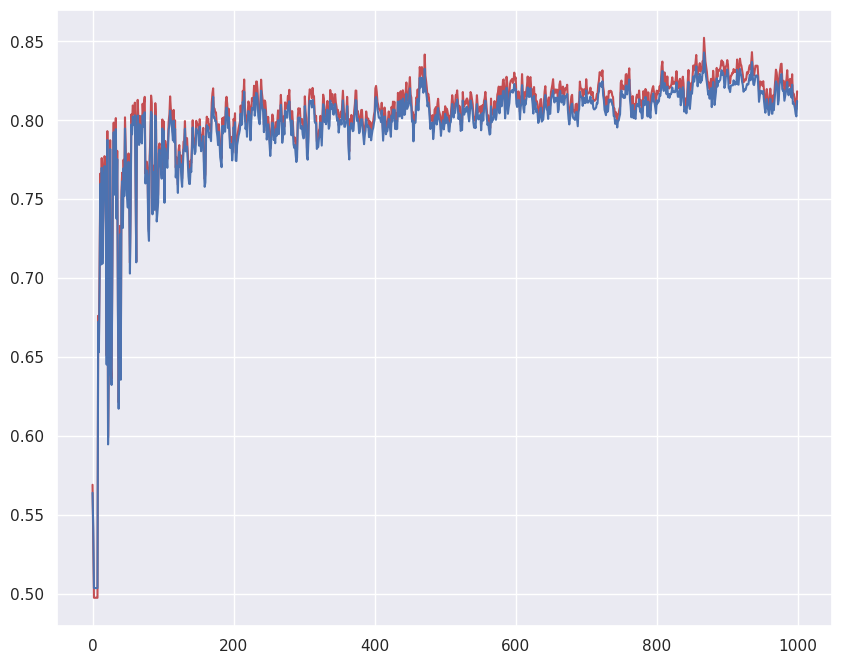

In [32]:
plt.figure(figsize=(10,8))
plt.plot(train_scores, 'r', test_scores, 'b')

## 4. Задание

* Обучим нашу модель **на всех данных**, преобразовав их через ```TfidfVectorizer``` с ```max_features=3000```.

* Параметры модели ```learning_rate=1.0, num_iters=1000, batch_size=256, reg=1e-3``` и выведем первые 5 самых важных фичей для класса 1 и 5 фичей для класса 0. Убедимся, что они коррелируют с вашей интуицией о хороших/плохих отзывах. 

**Hint:** зная индекс фичи, само слово вы можете получить, используя метод ```vectorizer.get_feature_names()```.

**Hint:** ```np.argsort```.

In [33]:
# Обучите модель
vectorizer = TfidfVectorizer(max_features=3000)
X = vectorizer.fit_transform(review_summaries)
y = train_df.Prediction.values
clf = LogisticRegression()
clf.train(X, y, verbose=True, learning_rate=1.0, num_iters=1000, batch_size=256, reg=1e-3)

iteration 0 / 1000: loss 0.694297
iteration 100 / 1000: loss 0.625033
iteration 200 / 1000: loss 0.588444
iteration 300 / 1000: loss 0.588487
iteration 400 / 1000: loss 0.582986
iteration 500 / 1000: loss 0.587562
iteration 600 / 1000: loss 0.562963
iteration 700 / 1000: loss 0.595838
iteration 800 / 1000: loss 0.591215
iteration 900 / 1000: loss 0.595899


In [34]:
# Получите индексы фичей
pos_features = np.argsort(clf.w)[-5:]
neg_features = np.argsort(clf.w)[:5]

In [36]:
# Выведите слова
fnames = vectorizer.get_feature_names_out()
print([fnames[p] for p in pos_features])
print([fnames[n] for n in neg_features])

['excellent', 'delicious', 'love', 'best', 'great']
['not', 'disappointed', 'bad', 'too', 'but']


## 5. Сравнение с sklearn.linear_model.LogisticRegression

Обучите такую же модель, но из пакета ```sklearn.linear_model``` и убедитесь, что ваша имплементация ничем не хуже (ну или почти не хуже).

In [37]:
from sklearn import linear_model

In [39]:
clf = linear_model.SGDClassifier(max_iter=1000, random_state=42, loss="log", penalty="l2", alpha=1e-3, eta0=1.0, learning_rate="constant")
clf.fit(X_train, y_train)

/home/shevelsm/programs/miniconda3/envs/hw7-logreg/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


SGDClassifier(alpha=0.001, eta0=1.0, learning_rate='constant', loss='log',
              random_state=42)

In [40]:
print("Train accuracy = %.3f" % accuracy_score(y_train, clf.predict(X_train)))
print("Test accuracy = %.3f" % accuracy_score(y_test, clf.predict(X_test)))

Train accuracy = 0.816
Test accuracy = 0.812
